This notebook transforms the text in emails into word vectors.
Text is **not preprocessed**, but tokenized using `nltk`.

Use this notebook to view similar words with the persisted word2vec model.
See the checkpoint section.

The end of this notebook has a viz for the wordvectors in 2 dimensional space.

In [42]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters

In [33]:
word_tokenize('dog hat')

['dog', 'hat']

In [35]:
st2 = nltk.data.load('tokenizers/punkt/english.pickle')
punkt_param = PunktParameters()
punkt_param.abbrev_types = set(['dr', 'vs', 'mr.', 'mrs.', 'prof.', 'inc.'])

sentence_splitter = PunktSentenceTokenizer(punkt_param)

def tokenize_text(text):
    '''
    Turns a string into a tokenized list.
    TODO: preprocessing,
    convert email addresses to fixed_var, convert links to fixed_var,
    remove dumb formatting artifacts like "--", and more...
    
    text = re.sub(r'[^a-zA-Z1-9:@]', ' ', text)

    '''
    word_tokenize_list = word_tokenize(text.lower())
    return word_tokenize_list

In [ ]:
emails_df = pd.read_csv('data/emails_clean.tsv.gz', sep='\t', compression='gzip')

In [57]:
import sys
import unicddodedata
import string

We're going to tokenize the comments. We do this to fit the data into the word2vec model. This step takes a long time

In [43]:
comments = emails_df['content'].apply(tokenize_text).tolist()

Let's save comments in a bcolz file so we never have to tokenize it again...

In [92]:
import bcolz

def save_array(fname, arr):
    '''Save numpy array as bcolz file
    '''
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    

def load_array(fname):
    '''Load bcolz file as numpy array
    '''
    return bcolz.open(fname)[:]

In [23]:
save_array('/scratch/ly501/comment_tokens.bc', comments)

In [ ]:
comments = load_array('/scratch/ly501/comment_tokens.bc')

This fits word2vec. The arguments mean: we're going to run through the data 5 times to git the model, we're going to look at the 7 words closest to any given word to figure out a relationship, we're only going to vectorize words that occur at least 5 times in out corpus, we're generating 100 dimensions for each word, and using 8 CPUs to compute this.

In [ ]:
comments[0]

In [51]:
model = Word2Vec([c for c in comments],
    iter=5, window=7, min_count=10, size=100, workers=8
)

In [12]:
model.wv.most_similar(positive=['flower'], topn=10)

[('luxurious', 0.7352564334869385),
 ('spas', 0.7350593209266663),
 ('cuisine', 0.7339888215065002),
 ('beautiful', 0.7268487215042114),
 ('magnificent', 0.7228542566299438),
 ('champagne', 0.7226847410202026),
 ('stylish', 0.721890926361084),
 ('scenic', 0.7114731669425964),
 ('exquisite', 0.7113041281700134),
 ('elegant', 0.7052590847015381)]

In [53]:
model.save('data/w2v')

<hr>
Checkpoint
<hr>

In [2]:
model = Word2Vec.load('data/w2v')

In [3]:
model.wv.most_similar_cosmul(positive=['woman', 'boy'], negative=['man'])[0]

('girl', 0.9495165348052979)

In [89]:
model.wv.most_similar(positive=['golf'], topn=10)

[('tennis', 0.7914378046989441),
 ('yoga', 0.7146831750869751),
 ('volleyball', 0.6891258955001831),
 ('tourney', 0.6708385944366455),
 ('bbq', 0.6668015122413635),
 ('tournament', 0.6648141741752625),
 ('golfers', 0.6614013910293579),
 ('astros', 0.655251145362854),
 ('soccer', 0.6526631712913513),
 ('softball', 0.6526517271995544)]

## Visualizing Word Vectors
The original model mapped each word to 100 dimensions.

We can remove stopwords (like _the_), and use **t-SNE** to simplify the data, and visualze it

In [18]:
df_w = pd.DataFrame([{'word': word, 'count':vocab_obj.count, 'index':vocab_obj.index} 
                     for word, vocab_obj in model.wv.vocab.items()])

In [79]:
# sw.append(['--', ''])

In [19]:
sw = stopwords.words('english')
df_w = df_w[~df_w['word'].isin(sw)]

Let's see the most and least used words...

In [20]:
df_w.sort_values(by='count', ascending=False, inplace=True)

In [81]:
df_w.head(20)

,count,index,word
47,7571255,0,","
186,5429919,2,--
16,5066359,3,.
143,3383579,5,:
199,3171895,6,>
146,2297076,9,@
135,1502716,12,?
197,1384295,14,<
194,1296326,15,''
123,1274954,16,)


Note these top words are mostly symbols are artifacts of not processing emails with long threads.

In [84]:
df_w.iloc[30:35]

,count,index,word
271,275267,68,energy
548,271288,69,new
204,248636,72,'
2244,239970,74,message
1417,238762,75,said


In [22]:
df_w.tail()

,count,index,word
216773,5,320842,no-reply
303852,5,335292,33256.
303853,5,335293,33079.
303856,5,335294,'flight
169990,5,316174,scary=20


## Using t-SNE to reduce `N`-dimensions to 2.
t-SNE is a dimensionality reduction tool.

In [24]:
vecs = model[df_w['word'].tolist()]
words = df_w['word'].tolist()

tsne = TSNE(n_components=2, random_state=0)
X = tsne.fit_transform(vecs[:2000])

We can go from these 100 dimensions,

In [85]:
words[0], vecs[0]

(',', array([ -6.03924155e-01,  -4.39275414e-01,   6.38838887e-01,
         -1.55170286e+00,  -4.11162281e+00,   2.71751976e+00,
         -7.92545527e-02,  -1.48760378e+00,  -3.64526248e+00,
         -8.48977268e-01,  -5.92716336e-01,   2.99875140e-01,
         -1.43699062e+00,   3.89958549e+00,   2.15337634e+00,
         -1.11041725e+00,  -1.56462476e-01,   8.19977522e-01,
          5.84371090e-01,  -2.16830969e+00,   2.28258586e+00,
          3.85149431e+00,   3.08658276e-03,  -2.85314465e+00,
         -2.14058113e+00,   3.90103221e-01,   2.93620849e+00,
          2.89076984e-01,  -4.75848675e-01,   1.86762369e+00,
          1.73269200e+00,   1.31299722e+00,   3.41662765e-01,
         -8.71732906e-02,  -1.30475387e-01,  -2.19163680e+00,
          4.94519681e-01,   2.27872276e+00,   6.88255131e-01,
          2.38761783e+00,  -1.70547581e+00,   4.04298258e+00,
         -2.89385581e+00,  -5.45196831e-01,  -3.28189325e+00,
          1.53250742e+00,   8.72280180e-01,   4.69521809e+00,
   

to two dimensions:

In [86]:
words[0], X[0]

(',', array([ 4.44627368,  1.23918768]))

In [40]:
def plot_vecs(X, words, start=0, end=350):
    d1, d2 = 0, 1

    dat = X[start:end]
    plt.figure(figsize=(15,15))
    for label, x, y in zip(words[start:end], dat[:, d1], dat[:, d2]):
        plt.text(x, y, label, color=np.random.rand(3)*0.7,
                 fontsize=10)

    x_min, x_max = dat[:, 0].min() - 1, dat[:, 0].max() + 1
    y_min, y_max = dat[:, 1].min() - 1, dat[:, 1].max() + 1
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.axis('off')
    plt.show();

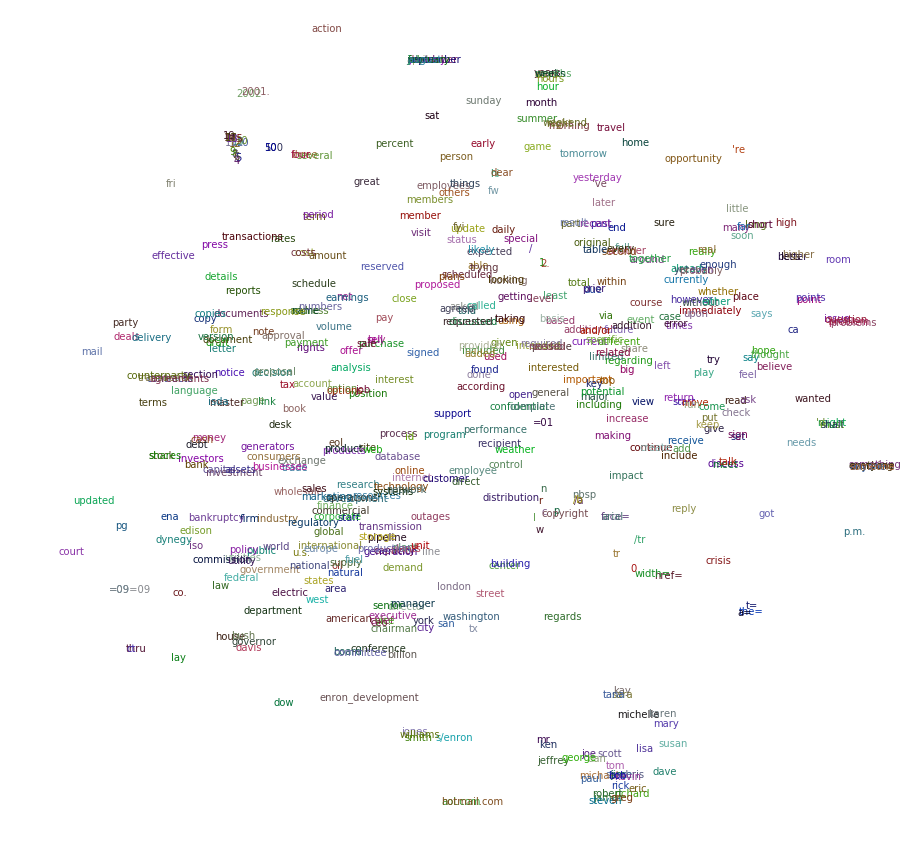

In [44]:
plot_vecs(X, words, start=100, end=400);